In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import misc, sparse, optimize, fft as scipy_fft
from matplotlib import pyplot, colors, cm
import embree
from pygltflib import GLTF2
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [2]:
class Scene3D:
    def __init__(self, filename, matrix):
        self.path = os.path.dirname(filename)

        self.gltf = GLTF2().load(filename)
        self.meshes = self.gltf.meshes[self.gltf.scenes[self.gltf.scene].nodes[0]].primitives

        self.vertex_buffers = []
        self.index_buffers = []

        self.device = embree.Device()
        self.scene = self.device.make_scene()

        for mesh in self.meshes:
            # Create geometry
            geometry = self.device.make_geometry(embree.GeometryType.Triangle)

            # Vertices
            accessor = self.gltf.accessors[mesh.attributes.POSITION]
            bufferView = self.gltf.bufferViews[accessor.bufferView]
            buffer = self.gltf.buffers[bufferView.buffer]
            data = self.gltf.get_data_from_buffer_uri(buffer.uri)

            vertex_size = 3 * np.dtype('float32').itemsize
            vertex_buffer = geometry.set_new_buffer(embree.BufferType.Vertex, 0, embree.Format.Float3, vertex_size, accessor.count)
            vertex_buffer[:] = np.frombuffer(data, dtype='float32', count=3*accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count, 3)

            # Matrix transform
            vertices = np.stack(np.broadcast_arrays(vertex_buffer[:, 0], vertex_buffer[:, 1], vertex_buffer[:, 2], 1), axis=-1)
            vertices = vertices @ matrix.T
            vertex_buffer[:] = vertices[:, 0:3]

            # Indices
            accessor = self.gltf.accessors[mesh.indices]
            bufferView = self.gltf.bufferViews[accessor.bufferView]
            buffer = self.gltf.buffers[bufferView.buffer]
            data = self.gltf.get_data_from_buffer_uri(buffer.uri)

            face_size = 3 * np.dtype('uint32').itemsize
            index_buffer = geometry.set_new_buffer(embree.BufferType.Index, 0, embree.Format.Uint3, face_size, accessor.count//3)
            index_buffer[:] = np.frombuffer(data, dtype='uint16', count=accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count//3, 3).astype(np.uint32)

            # Save reference to buffers.
            self.vertex_buffers.append(vertex_buffer)
            self.index_buffers.append(index_buffer)

            # Attach geometry to scene
            geometry.commit()
            self.scene.attach_geometry(geometry)
            geometry.release()

        self.scene.commit()

    def rayCast(self, ray_origins, ray_directions):
        rayhit = embree.RayHit1M(ray_origins.shape[0])
        rayhit.org[:] = ray_origins
        rayhit.dir[:] = ray_directions
        rayhit.tnear[:] = 0
        rayhit.tfar[:] = np.inf
        rayhit.flags[:] = 0
        rayhit.prim_id[:] = embree.INVALID_GEOMETRY_ID
        rayhit.geom_id[:] = embree.INVALID_GEOMETRY_ID

        context = embree.IntersectContext()
        self.scene.intersect1M(context, rayhit)

        ray_colors = np.empty((ray_origins.shape[0], 4), dtype=np.uint8)
        ray_colors[:] = [185, 222, 254, 255] # Background color.

        for mesh_id in range(len(self.meshes)):
            mesh = self.meshes[mesh_id]
            material = self.gltf.materials[mesh.material]
            base_color_tex = material.pbrMetallicRoughness.baseColorTexture

            # Load vertex UV coordinates.
            accessor = self.gltf.accessors[[mesh.attributes.TEXCOORD_0, mesh.attributes.TEXCOORD_1][base_color_tex.texCoord]]
            bufferView = self.gltf.bufferViews[accessor.bufferView]
            buffer = self.gltf.buffers[bufferView.buffer]
            data = self.gltf.get_data_from_buffer_uri(buffer.uri)

            vertex_uv = np.frombuffer(data, dtype='float32', count=2*accessor.count, offset=bufferView.byteOffset+accessor.byteOffset).reshape(accessor.count, 2)

            # Barycentric coordinates of each hit.
            mask = rayhit.geom_id == mesh_id
            hit_uv = rayhit.uv[mask, np.newaxis, :]

            # Texture coordinates of each vertex for each triangle hit.
            index_buffer = self.index_buffers[mesh_id]
            vertex_id = index_buffer[rayhit.prim_id[mask]]
            texture_uv = vertex_uv[vertex_id, :]

            # Interpolate the texture coordinate for each hit.
            interpolated_uv = (1.0 - hit_uv[..., 0] - hit_uv[..., 1]) * texture_uv[:, 0, :] + hit_uv[..., 0] * texture_uv[:, 1, :] + hit_uv[..., 1] * texture_uv[:, 2, :]

            # UV wrapping.
            wrapped_uv = interpolated_uv % 1.0

            # Load texture image.
            texture = self.gltf.textures[base_color_tex.index]
            tex_image = self.gltf.images[texture.source]

            with Image.open(os.path.join(self.path, tex_image.uri)) as img:
                image_array = np.array(img.convert('RGBA'))
                #image_array = np.flip(image_array, axis=0)
                image_array = np.swapaxes(image_array, 0, 1)

                image_coord = (wrapped_uv * image_array.shape[:-1]).astype(int)
                ray_colors[mask] = image_array[image_coord[:, 0], image_coord[:, 1]]
        
        return ray_colors
    
    def release(self):
        self.scene.release()
        self.device.release()

In [3]:
def array_stats(a):
    print('shape: ', a.shape, a.dtype, '| total size:', a.nbytes/2**30, 'GiB | range: [', np.amin(a), ',', np.amax(a), '] | average: ', np.average(a))


    
def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = values.T
    values = np.abs(values) if absolute else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values, axis=1) if flip else np.flip(values, axis=0)
    if len(values.shape) < 3:
        values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else np.clip(values, 0.0, 1.0)
        values = cm.get_cmap(color_map)(values, bytes=True)
    else:
        values = (values * np.nan_to_num(255.0 / np.amax(values))).astype(np.uint8) if normalize else np.clip(values * 255.0, 0.0, 255.0).astype(np.uint8)
    display(Image.fromarray(values))

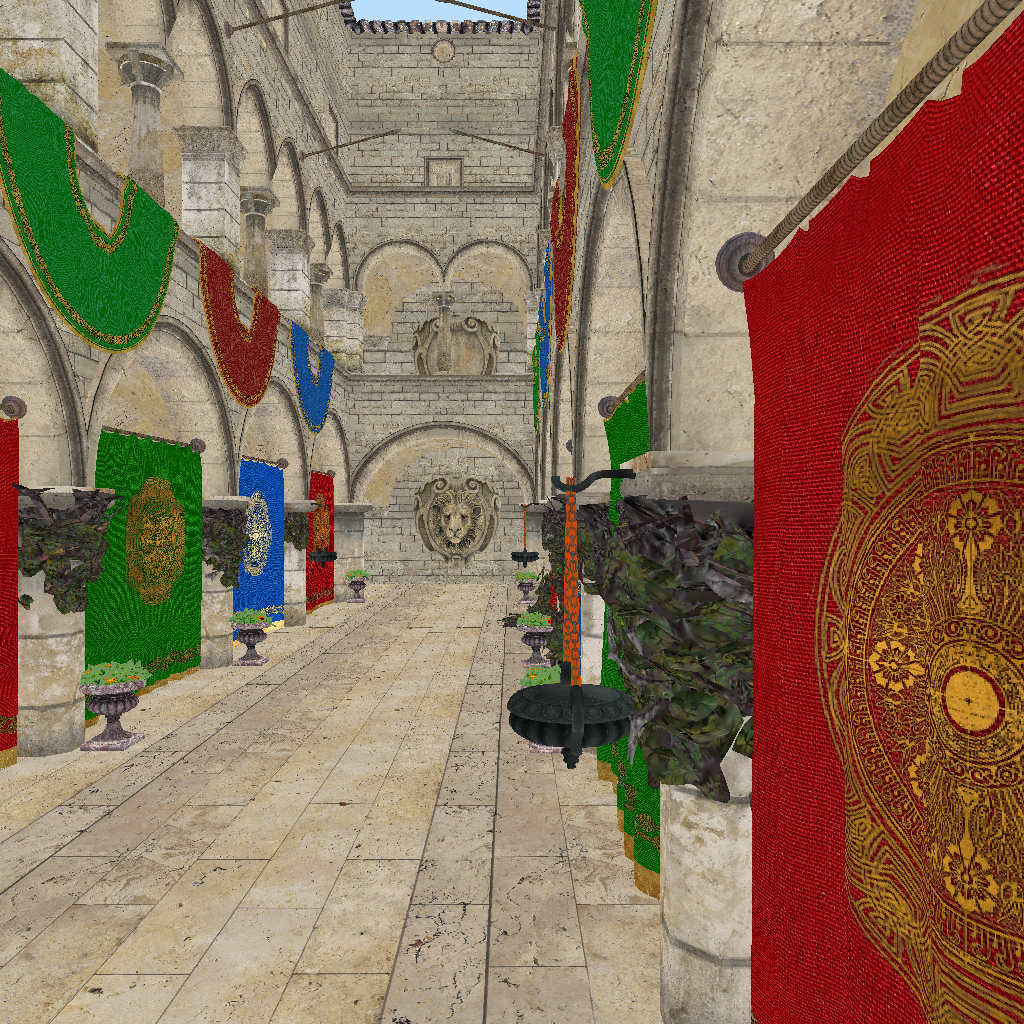

In [4]:
retina_size = 22.0

matrix = np.array([[ 0.0,  0.0,  1.0, -120.0],
                   [ 0.0,  1.0,  0.0, -200.0],
                   [ 1.0,  0.0,  0.0, -800.0],
                   [ 0.0,  0.0,  0.0,    1.0]])

scene = Scene3D('../models/gltf/sponza/Sponza.gltf', matrix)

res_x = 1024
res_y = 1024

org_x = np.zeros(res_x * res_y, dtype=cp.float32)
org_y = np.zeros(res_x * res_y, dtype=cp.float32)
org_z = np.zeros(res_x * res_y, dtype=cp.float32)

dst_x = np.repeat(np.linspace(-0.5, 0.5, num=res_x) * retina_size, res_y)
dst_y = np.tile(np.linspace(-0.5, 0.5, num=res_y) * retina_size, res_x)
dst_z = np.ones(res_x * res_y, dtype=cp.float32) * (-17.0)

ray_origins = np.stack(np.broadcast_arrays(org_x, org_y, org_z), axis=-1)
ray_directions = np.stack(np.broadcast_arrays(dst_x, dst_y, dst_z), axis=-1) - ray_origins

ray_colors = np.moveaxis(scene.rayCast(ray_origins, ray_directions)[..., 0:3] / 255.0, -1, 0).astype(np.float32).reshape(3, res_x, res_y)

scene.release()

display_image(ray_colors, normalize=False)